<a href="https://colab.research.google.com/github/calebdre/intro-ds-project/blob/master/colab_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!rm -rf idp

In [4]:
!git clone https://github.com/calebdre/intro-ds-project idp

Cloning into 'idp'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 115 (delta 60), reused 85 (delta 30), pack-reused 0
Receiving objects: 100% (115/115), 37.35 MiB | 16.78 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [0]:
!mv idp/* ./; mkdir transforms; cp "drive/My Drive/f_sents_prod.pkl" transforms; cp "/content/drive/My Drive/genre2_label _prod.pkl" transforms;

In [6]:
!python -m pip install -r requirements.txt

    100% |████████████████████████████████| 519.5MB 32kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x58a80000 @  0x7fab55a052a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 5.8MB 5.0MB/s 
    100% |████████████████████████████████| 2.0MB 4.7MB/s 
  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /root/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from data_transform_pipeline import DataTransformPipeline
from data import Data
from sklearn.model_selection import train_test_split
from tensorboard_logger import Logger
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
%matplotlib inline
plt.rcParams["figure.figsize"] = (14,9)

In [0]:
embeds, idx_word_map, embedding_vocab = DataTransformPipeline.load("f_sents_prod").data
embedding_vocab = torch.stack(list(embedding_vocab.values()))

y, mapping = DataTransformPipeline.load("genre2_label _prod").data
y = y.values.tolist()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(embeds, y, test_size=0.1, random_state = 42)

train_data = Data(X_train, y_train)
train_loader = train_data.get_loader(batch_size = 32)

val_data = Data(X_test, y_test)
val_loader = val_data.get_loader()

In [0]:
class RNN(nn.Module):
    def __init__(self, embedding, embedding_size, hidden_size, num_layers, num_classes):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        super(RNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(embedding)
        self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, batch_first=True, bidirectional = True, dropout = .5)
        self.linear = nn.Linear(hidden_size * 2, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers * 2, batch_size, self.hidden_size).cuda()

        return hidden

    def forward(self, x):
        # reset hidden state

        batch_size, seq_len = x.size()

        self.hidden = self.init_hidden(batch_size)
        x = x.long()

        # get embedding of characters
        embed = self.embedding(x)
        rnn_out, self.hidden = self.rnn(embed, self.hidden)
        # undo packing
        rnn_out = torch.sum(rnn_out, dim=1)

        logits = self.linear(rnn_out)
        logits = F.log_softmax(logits, dim=1)
        return logits


In [0]:
class GRU(nn.Module):
    def __init__(self, embedding, embedding_size, hidden_size, num_layers, num_classes):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        super(GRU, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(embedding)
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers, batch_first=True, bidirectional = True, dropout = .5)
        self.linear = nn.Linear(hidden_size * 2, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers * 2, batch_size, self.hidden_size).cuda()

        return hidden

    def forward(self, x):
        # reset hidden state

        batch_size, seq_len = x.size()

        self.hidden = self.init_hidden(batch_size)
        x = x.long()

        # get embedding of characters
        embed = self.embedding(x)
        gru_out, self.hidden = self.gru(embed, self.hidden)
        # undo packing
        gru_out = torch.sum(gru_out, dim=1)

        logits = self.linear(gru_out)
        logits = F.log_softmax(logits, dim=1)
        return logits


In [0]:
class LSTM(nn.Module):
    def __init__(self, embedding, embedding_size, hidden_size, num_layers, num_classes):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        super(LSTM, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(embedding)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True, bidirectional = True, dropout = .5)
        self.linear = nn.Linear(hidden_size * 2, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers, batch_size, self.hidden_size).cuda()

        return hidden

    def forward(self, x):
        # reset hidden state

        batch_size, seq_len = x.size()

        self.hidden = self.init_hidden(batch_size)
        x = x.long()

        # get embedding of characters
        embed = self.embedding(x)
        lstm_out, self.hidden = self.lstm(embed)
        # undo packing
        lstm_out = torch.sum(lstm_out, dim=1)

        logits = self.linear(lstm_out)
        logits = F.log_softmax(logits, dim=1)
        return logits


In [0]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model = model.cuda()
    model.eval()
    for lengths, labels, data in loader:
        lengths, labels, data = lengths.cuda(), labels.cuda(), data.cuda()
        outputs = F.softmax(model(data), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [0]:
def train(train_loader, val_loader, model, logger = None, lr=3e-8, epochs = 8):
    learning_rate = lr
    num_epochs = epochs # number epoch to train

    # Criterion and Optimizer
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    model = model.cuda()
    total_step = len(train_loader)
    step_counter = 0
    losses = []
    for epoch in range(num_epochs):
        print("Epoch {}".format(epoch+1))
        for i, (lengths, labels, data) in enumerate(train_loader):
            lengths, labels, data = lengths.cuda(), labels.cuda(), data.cuda()
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data)
            loss = loss_fn(outputs, labels)
            logger.log_value("loss", loss.item(), step_counter)
            losses.append(loss.item())
            # Backward and optimize
            loss.backward()
            optimizer.step()
            
            if i > 0 and i % 250 == 0:
                val_acc = test_model(val_loader, model)
                logger.log_value("validation accuracy", val_acc, step_counter)
                print('Epoch: [{}/{}] \t Step: [{}/{}] \tValidation Acc: [{:.4f}]'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
            step_counter += 1
        print()
    return losses, model, val_acc

In [0]:
def train_rnn(train_loader, val_loader, hidden_size, num_layers, logger = None):
    model = RNN(embedding_vocab, embedding_vocab.shape[1], hidden_size, num_layers, np.unique(y).shape[0])
    train(train_loader, val_loader, model, logger)

In [0]:
import IPython
LOG_DIR = '/tmp/log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6007 &'
    .format(LOG_DIR)
)
url = "http://127.0.0.1:6007/"
iframe = "<iframe src='{}' width=1100 height=800></iframe>".format(url)
IPython.display.HTML(iframe)

In [0]:
hidden_size = [350, 350, 350, 350, 400, 400, 400, 400, 500, 500, 500, 500]
num_layers =  [  3,   4,   5,   6,   3,   4,   5,   6,   3,   4,   5,   6]

for i, params in enumerate(zip(hidden_size, num_layers)):
    t = ["{}: {}".format(name, val) for name, val in [("hidden size", params[0]), ("num layers", params[1])]]
    print("-------------------\nTraining Parameters\n-------------------\n\n{}\n-------------------".format("\n".join(t)))
    train_rnn(train_loader, val_loader, *params, Logger("runs/{}".format("_".join(t))))
    print()

In [0]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# original: https://github.com/Shawn1993/cnn-text-classification-pytorch/blob/master/model.py
class CNN_Text(nn.Module):
    def __init__(self, args):
        super(CNN_Text, self).__init__()
        self.args = args
        
        D = args["embed_size"]
        C = args['class_num']
        Ci = 1
        Co = args['kernel_num']

        self.embedding = nn.Embedding.from_pretrained(args['embedding'].cuda())
        # self.convs1 = [nn.Conv2d(Ci, Co, (K, D)) for K in Ks]
        self.convs1 = nn.ModuleList([nn.Conv2d(Ci, Co, (K, D)) for K in range(3, 6)])
        '''
        self.conv13 = nn.Conv2d(Ci, Co, (3, D))
        self.conv14 = nn.Conv2d(Ci, Co, (4, D))
        self.conv15 = nn.Conv2d(Ci, Co, (5, D))
        '''
        self.dropout = nn.Dropout(.5)
        self.fc1 = nn.Linear(3*Co, C)

    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)  # (N, Co, W)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x

    def forward(self, x):
        x = self.embedding(x.long())  # (N, W, D)

        x = x.unsqueeze(1)  # (N, Ci, W, D)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)

        x = torch.cat(x, 1)

        '''
        x1 = self.conv_and_pool(x,self.conv13) #(N,Co)
        x2 = self.conv_and_pool(x,self.conv14) #(N,Co)
        x3 = self.conv_and_pool(x,self.conv15) #(N,Co)
        x = torch.cat((x1, x2, x3), 1) # (N,len(Ks)*Co)
        '''
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        return logit.cuda()


In [0]:
args = {
    'embedding': embedding_vocab,
    'embed_size': embedding_vocab.shape[1],
    'class_num': np.unique(y).shape[0],
    'kernel_num': 400
}

In [0]:
def train_models(train_loader, val_loader, models, logger, lr, epochs, label, window = 50):
  all_losses = []
  for i, model in enumerate(models):
    print("\n****************\nRunning {}\n****************\n".format(label(i)))
    losses, model = train(train_loader, val_loader, cnn, Logger("runs/cnn"), lr=lr, epochs = epochs)
    all_losses.append(losses)
    plt.plot(pd.Series(losses).rolling(window).mean().dropna(), label=label(i))    
  
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()
  return all_losses, models

In [0]:
lrs = [3e-3, 3e-4, 3e-5, 3e-6]
for lr in lrs:
  print("\n**************************\nTesting LR = {}\n**************************\n".format(lr))
  cnn = CNN_Text(args)
  losses, model = train(train_loader, val_loader, cnn, Logger("runs/cnn"), lr=lr, epochs = 8)
  plt.plot(pd.Series(loss).rolling(100).mean().dropna(), label="lr = {}".format(lr))
 

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
k_params = [{**args, "kernel_num": i} for i in [150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650]]
lr = 3e-5
epochs = 5
window = 1500
models = [CNN_Text(param) for param in k_params]
losses, models = train_models(train_loader, val_loader, models, Logger("runs/cnn"), lr=lr, epochs = epochs, window = window, label = lambda i: "Kernel_num = {}".format(k_params[i]["kernel_num"]))

In [19]:
default_params = {
    'embedding': embedding_vocab,
    'embedding_size': embedding_vocab.shape[1],
    'num_classes': np.unique(y).shape[0],
    'num_layers': 2
}

hidden_sizes = [100, 250, 400, 600, 800]
lr = 3e-4
epochs = 6
models = [LSTM, RNN, GRU]

trials = []
for hidden_size in hidden_sizes:
  for model in models:
    print("***********************\nModel:        {}\nHidden Size:  {}\n***********************\n".format(model.__name__, hidden_size))
    params = {'hidden_size': hidden_size, **default_params}
    m = model(**params)
    losses, trained_m, val_acc = train(train_loader, val_loader, m, Logger("runs/cnn"), lr=lr, epochs = epochs)
    info = {
        "model_name": model.__name__,
        "trained_model": trained_m,
        "losses": losses,
        "val_accuracy": val_acc,
        "parameters": {
            'learning_rate': lr,
            'epochs': epochs,
            **params
        }
    }
    trials.append(info)

with open("seq_nets_trials.torch", "wb+") as f:
  torch.save(trials, f)

***********************
Model:        LSTM
Hidden Size:  100
***********************

Epoch 1
Epoch: [1/6] 	 Step: [251/692] 	Validation Acc: [36.2454]
Epoch: [1/6] 	 Step: [501/692] 	Validation Acc: [33.4011]

Epoch 2
Epoch: [2/6] 	 Step: [251/692] 	Validation Acc: [34.1731]
Epoch: [2/6] 	 Step: [501/692] 	Validation Acc: [38.7647]

Epoch 3
Epoch: [3/6] 	 Step: [251/692] 	Validation Acc: [41.1621]
Epoch: [3/6] 	 Step: [501/692] 	Validation Acc: [42.0561]

Epoch 4
Epoch: [4/6] 	 Step: [251/692] 	Validation Acc: [39.8618]
Epoch: [4/6] 	 Step: [501/692] 	Validation Acc: [41.8529]

Epoch 5
Epoch: [5/6] 	 Step: [251/692] 	Validation Acc: [40.9996]
Epoch: [5/6] 	 Step: [501/692] 	Validation Acc: [40.3088]

Epoch 6
Epoch: [6/6] 	 Step: [251/692] 	Validation Acc: [41.4059]
Epoch: [6/6] 	 Step: [501/692] 	Validation Acc: [42.5843]

***********************
Model:        RNN
Hidden Size:  100
***********************

Epoch 1
Epoch: [1/6] 	 Step: [251/692] 	Validation Acc: [33.4417]
Epoch: [1/6] 

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type GRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [21]:
!python -m pip install tabulate

    100% |████████████████████████████████| 51kB 4.3MB/s 
  Running setup.py bdist_wheel for tabulate ... - done
  Stored in directory: /root/.cache/pip/wheels/2a/85/33/2f6da85d5f10614cbe5a625eab3b3aebfdf43e7b857f25f829
Successfully built tabulate


In [0]:
with open("seq_nets_trials.torch", "rb") as f:
  ys = torch.load(f)

In [0]:
lstms = [y for y in ys if y["model_name"] == "LSTM"]
rnns = [y for y in ys if y["model_name"] == "RNN"]
grus = [y for y in ys if y["model_name"] == "GRU"]

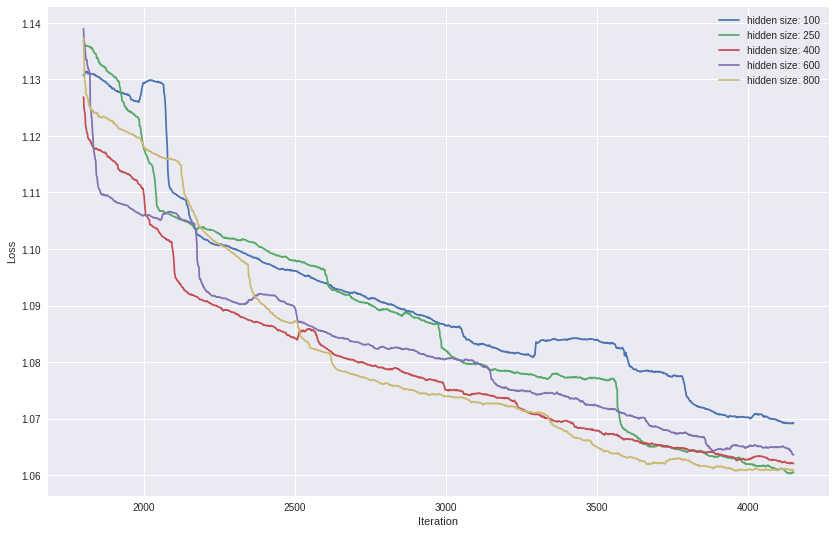

In [46]:
for lstm in lstms:
  plt.plot(pd.Series(lstm["losses"]).rolling(1800).mean(), label="hidden size: {}".format(lstm["parameters"]["hidden_size"]))
 
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

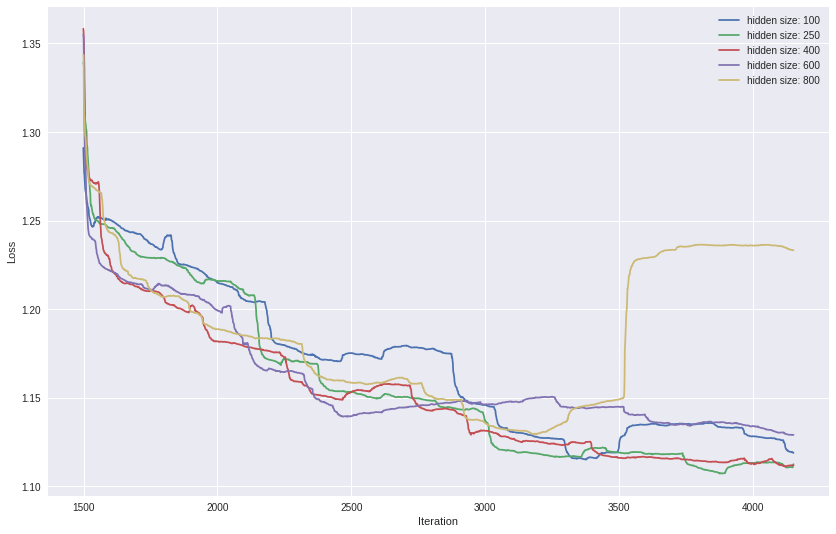

In [48]:
for rnn in rnns:
  plt.plot(pd.Series(rnn["losses"]).rolling(1500).mean(), label="hidden size: {}".format(rnn["parameters"]["hidden_size"]))
 
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

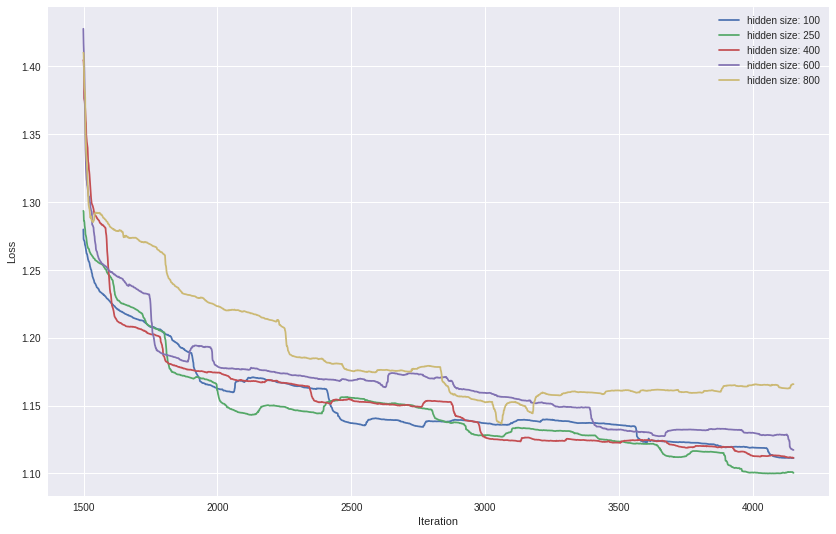

In [49]:
for gru in grus:
  plt.plot(pd.Series(gru["losses"]).rolling(1500).mean(), label="hidden size: {}".format(gru["parameters"]["hidden_size"]))
 
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()